In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
datetime.now()

datetime.datetime(2020, 8, 15, 15, 11, 51, 502539)

In [3]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [4]:
url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
driver.get(url)

### Extract date

In [5]:
content = driver.page_source
soup =BeautifulSoup(content, 'lxml')


In [6]:
data = soup.findAll(text=re.compile("截至.+"))
data

['try { window.getTimelineService1 = [{"id":75940,"pubDate":1597491751000,"pubDateStr":"2小时前","title":"国际移民组织：今年至少1200名移民丧生","summary":"根据联合国新闻，新冠肺炎疫情暴发后各国采取措施限制人口流动，但国际移民组织记录显示，今年上半年仍有1200多名移民在途中丧生。而由于疫情期间收集数据困难重重，因此实际人数可能远超这一数字。国际移民组织当地时间14日表示，针对新冠肺炎疫情采取的关闭边境等系列应对措施增加了移民在途中的危险。同时，人道主义支持和救援亦越来越少。由于边界封闭，许多移民无法到达安全的目的地，也无法获得医疗服务。","infoSource":"央视新闻app","sourceUrl":"http://app.cctv.com/special/cportal/detail/arti/index.html?id=ArtivrebO4oqBS8NDY2EqvJf200815&isfromapp=1","provinceId":""},{"id":75923,"pubDate":1597487998000,"pubDateStr":"3小时前","title":"8月17日起 香港始发至北京旅客需出示核酸检测阴性证明","summary":"自2020年8月17日起，所有由香港前往北京的航空旅客，须出示由特区政府承认的检测机构发出的新冠病毒核酸检测证明，其结果必须为阴性。有关检测须在旅客登机前7日内进行。有出行需求的旅客需提前向航空公司了解详情。\\n温馨提醒：由海外其他航点经香港转机、过境至包括北京等中国内地各目的地的服务仍然暂停，直至另行通知。","infoSource":"央视新闻app","sourceUrl":"http://app.cctv.com/special/cportal/detail/arti/index.html?id=Arti4eQYumSkiXaNa059JsQC200815&isfromapp=1","provinceId":""},{"id":75912,"pubDate":1597485016000,"pubDateStr":"4小时前","title":"北京新发地主市场南区今天复市，只批发不零售"

In [7]:
for s in data:
    m = re.search("截至.*(202\d-\d+-\d+ \d+:\d+)", s)
    if m is not None:
        data_date_time = m.group(1)
data_date_time

'2020-08-15 20:51'

### Extract data (summary)

In [8]:
data = soup.findAll(text=re.compile('\"summary.+\"confirmedCount\":\d'))

data


['try { window.getStatisticsService = {"id":1,"createTime":1579537899000,"modifyTime":1597495880000,"infectSource":"该字段已替换为说明2","passWay":"该字段已替换为说明3","imgUrl":"https://img1.dxycdn.com/2020/0201/450/3394153392393266839-135.png","dailyPic":"https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png,https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png,https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png,https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png,https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png,https://img1.dxycdn.com/2020/0211/089/3395998939840182072-135.png","dailyPics":["https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png","https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png","https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png","https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png","https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png","https://i

In [9]:
m = re.search('\"confirmedCount\":(\d+)', data[0])
summary_confirmed_count = int(m.group(1))


m = re.search('\"curedCount\":(\d+)', data[0])
summary_cured_count = int(m.group(1))

m = re.search('\"deadCount\":(\d+)', data[0])
summary_dead_count = int(m.group(1))


In [10]:
# make a dataframe
df = pd.DataFrame({
    'datetime': data_date_time,
    'confirmed': summary_confirmed_count,
    'cured': summary_cured_count,
    'dead': summary_dead_count
}, index=[0])
df

,datetime,confirmed,cured,dead
0,2020-08-15 20:51,89742,83501,4708


### Save to file

In [11]:
from pathlib import Path
csv_file = '../data/china-summary-cases.csv'

if Path(csv_file).exists():
    # read out the old data - then merge with new data and remove duplicates based on datetime
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)

In [12]:
df.sort_values(by=['datetime'], inplace=True)

df.to_csv(csv_file, index=False)


### Plot graph

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = '../images/china-summary-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

df.set_index('datetime_idx', inplace=True)
df.drop(['datetime'], axis=1, inplace=True)


In [14]:
df

,confirmed,cured,dead
datetime_idx,,,
2020-02-02 10:22:00,14483,379,304
2020-02-02 10:28:00,14483,380,304
2020-02-02 11:19:00,14489,385,304
2020-02-02 11:54:00,14489,397,304
2020-02-02 15:01:00,14490,430,304
...,...,...,...
2020-08-15 16:08:00,89695,83407,4708
2020-08-15 16:31:00,89695,83407,4708
2020-08-15 18:40:00,89742,83501,4708


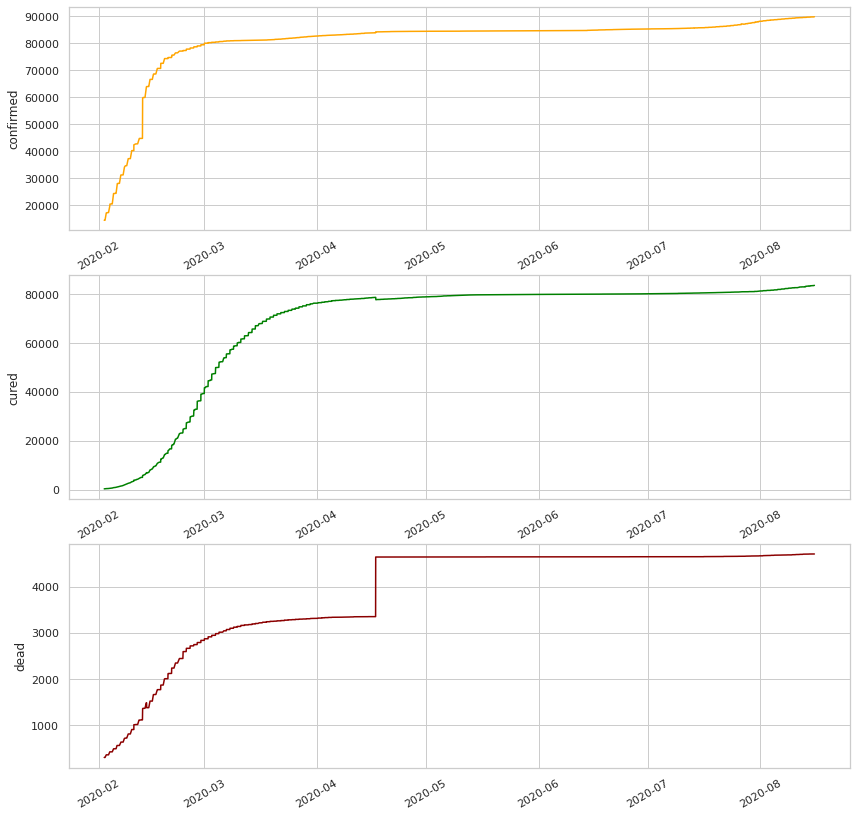

In [15]:
if df.shape[0]>1:
    # line chart when having at least a few points
    sns.set(rc={'figure.figsize':(14,14)})
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(nrows=3)

    sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
    sns.lineplot(x=df.index, y = 'cured', data=df, ax= axs[1], estimator=None, color='green')
    sns.lineplot(x=df.index, y = 'dead', data=df, ax= axs[2], estimator=None, color='darkred')

    for ax in axs:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
else:

    ax = df.plot(kind='bar', stacked=True, figsize=(9,6))
    fig = ax.get_figure()
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(0) 


In [16]:
fig.savefig(png_file)